Displays JWST/MIRI 21µm and Spitzer/MIPS 24µm images to highlight differences in angular resolution. The MIPS data, which has a considerably larger FOV, is projected onto the footprint of the JWST data to enable a direct comparison.

In [50]:
# Inputs

# JWST and MIPS fits file names and directory paths
dir_jwst = '/home/mtr/Downloads/jw03435/level_3/'
dir_mips = '/home/mtr/Downloads/MIPS_LGImages-1-part1/data/SPITZER/MIPS_LG/images/'
image_file_jwst = 'jw03435-o002_t001_miri_f2100w_i2d.fits.gz'
image_file_mips = 'ngc5194_24_img.fits'

# Values below for convolving JWST data to MIPS resolution
jwst_pixscale = 0.11  # MIRI F2100W pixel scale
# FWHM of PSFs
jwst_fwhm = 0.7  # JWST MIRI F2100W PSF FWHM 
mips_fwhm = 6.0  # MIPS 24µm PSF FWHM 

# Plot parameters
xsize = 15 
ysize = 12
flux_min = -3
flux_max = 30

In [51]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from astropy.wcs import WCS
#from astropy.stats import sigma_clipped_stats
from reproject import reproject_interp
from astropy.convolution import Gaussian2DKernel, convolve_fft

In [52]:
def display_image_data(image_data,xsize,ysize,flux_min,flux_max):
    # Plot image_data 
    plt.figure(figsize=(xsize,ysize))
    plt.gcf().set_facecolor("black")
    plt.imshow(image_data, cmap='gist_heat', vmin=flux_min, vmax=flux_max)
    plt.axis('off')

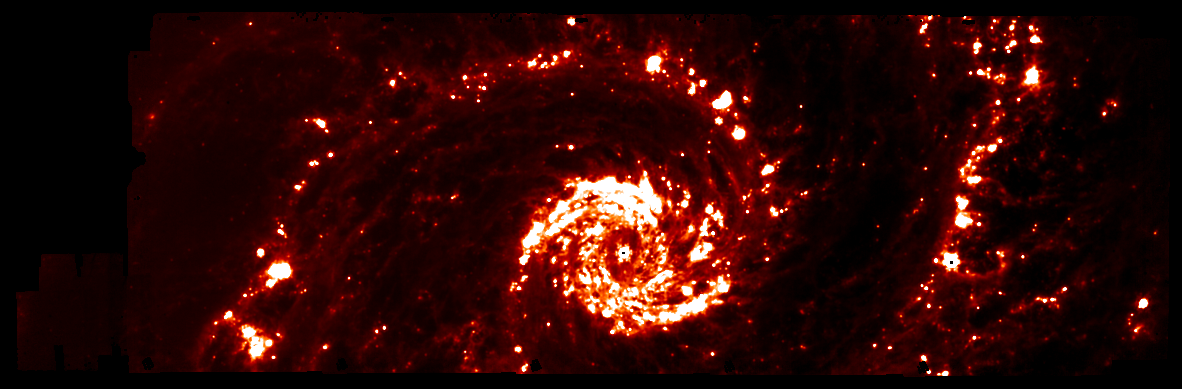

In [53]:
# Read JWST data and header
hdu_list = fits.open(dir_jwst + image_file_jwst)

image_data_jwst = hdu_list[1].data
image_header_jwst = hdu_list[1].header

display_image_data(image_data_jwst,xsize,ysize,flux_min,flux_max)

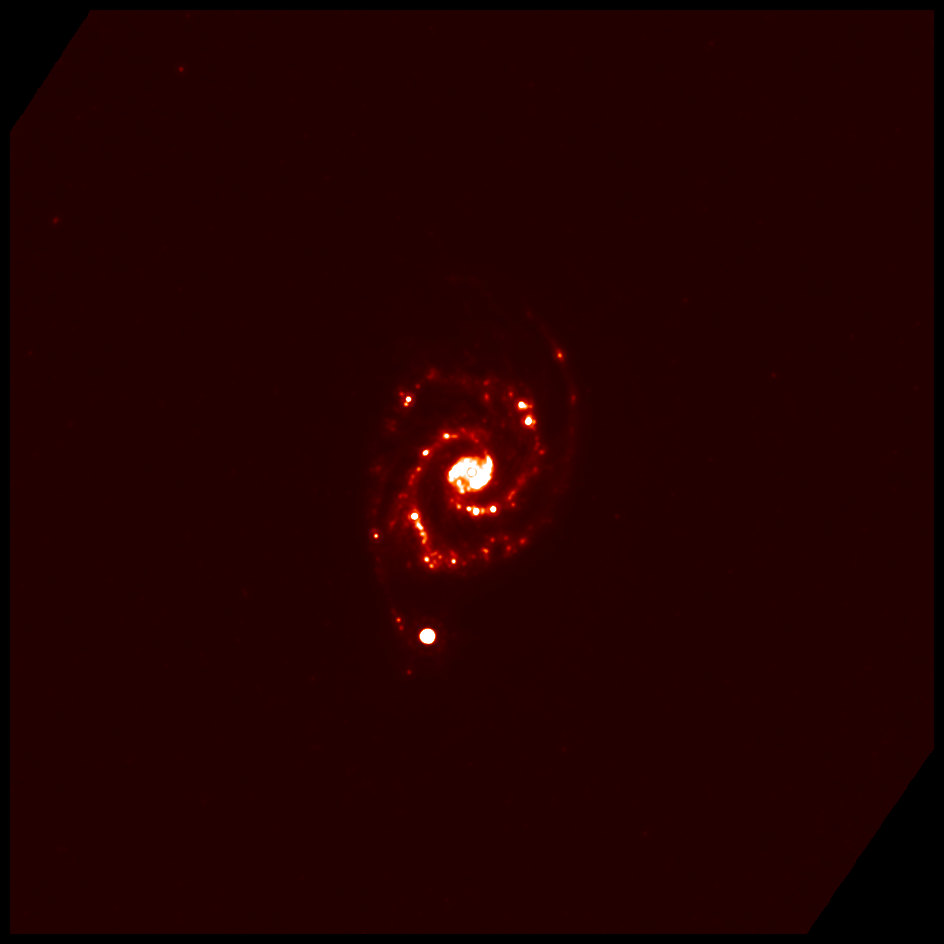

In [54]:
# Read MIPS data and header
hdu_list = fits.open(dir_mips + image_file_mips)
image_data_mips = hdu_list[0].data
image_header_mips = hdu_list[0].header

display_image_data(image_data_mips,xsize,ysize,flux_min,flux_max)

In [55]:
# Set negative values to zero in JWST data
image_data_jwst[image_data_jwst < 0] = 0

# Create a mask of NaN values in JWST data
jwst_nan_mask = np.isnan(image_data_jwst)

Project the MIPS data onto the footprint of the JWST data

Set DATE-AVG to '2024-05-31T17:39:19.434' from MJD-AVG.
Set DATE-END to '2024-05-31T20:13:08.478' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -33.098648 from OBSGEO-[XYZ].
Set OBSGEO-H to 1708151795.253 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


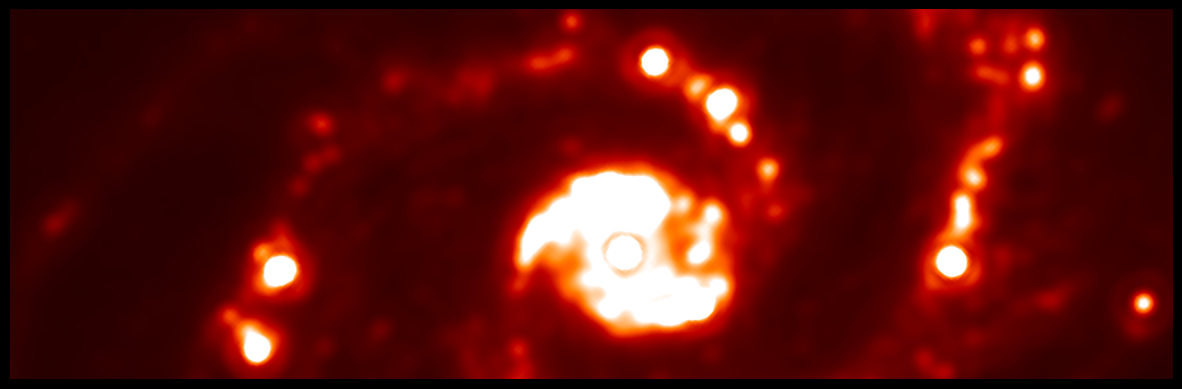

In [56]:
# Create a new HDU with the MIPS data and its original header
mips_hdu = fits.PrimaryHDU(data=image_data_mips, header=image_header_mips)
mips_hdul = fits.HDUList([mips_hdu])

# Reproject the MIPS data to the JWST coordinate system
reprojected_mips, footprint = reproject_interp(mips_hdul, image_header_jwst)

display_image_data(reprojected_mips,xsize,ysize,flux_min,flux_max)

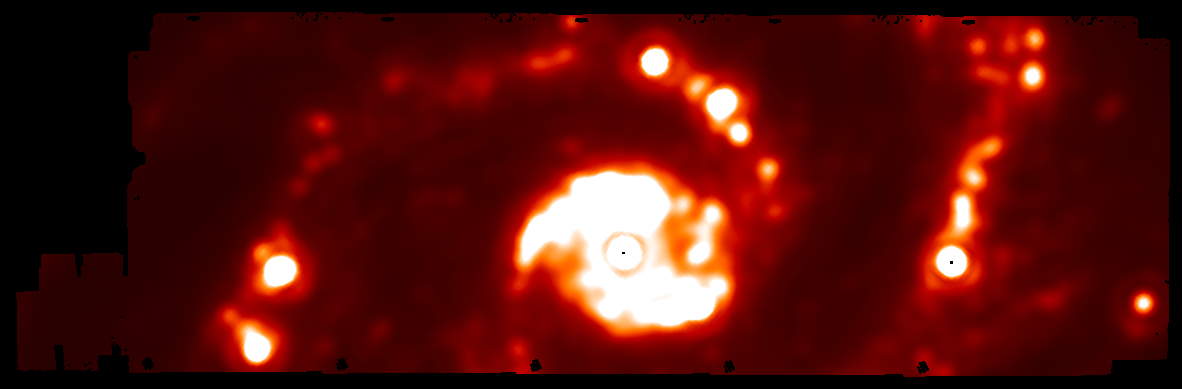

In [57]:
# Apply the JWST NaN mask to the reprojected MIPS data
reprojected_mips[jwst_nan_mask] = np.nan

display_image_data(reprojected_mips,xsize,ysize,flux_min,flux_max)

Convolve JWST data to MIPS resolution, assuming gaussian PSFs

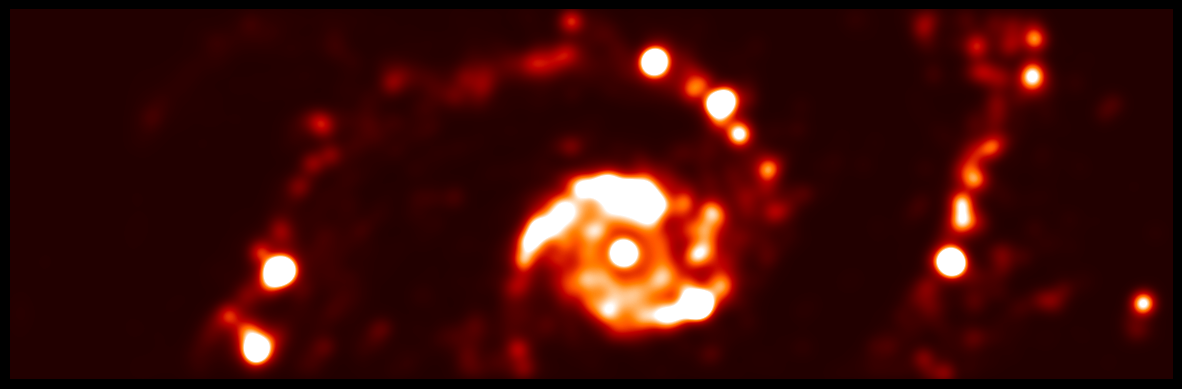

In [58]:

# Calculate the required sigma for the kernel (in JWST pixels)
target_fwhm = np.sqrt(mips_fwhm**2 - jwst_fwhm**2)  # Quadrature difference
sigma_pix = target_fwhm / 2.355 / jwst_pixscale

# Create a Gaussian kernel
kernel = Gaussian2DKernel(x_stddev=sigma_pix)

# Apply convolution to JWST data
jwst_convolved = convolve_fft(image_data_jwst, kernel, fill_value=0, normalize_kernel=True, allow_huge=True, nan_treatment='fill')

display_image_data(jwst_convolved,xsize,ysize,flux_min,flux_max)

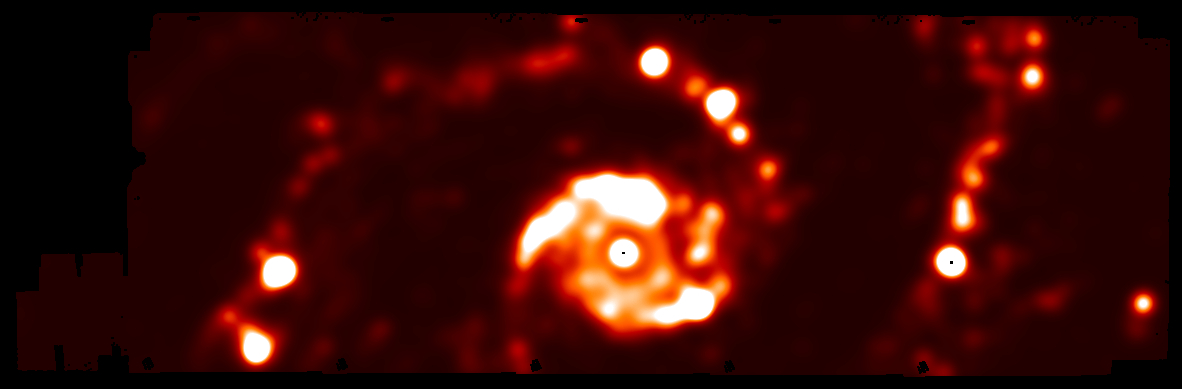

In [59]:
# Re-apply the NaN mask
jwst_convolved[jwst_nan_mask] = np.nan

display_image_data(jwst_convolved,xsize,ysize,flux_min,flux_max)

Create a figure with three subplots stacked vertically

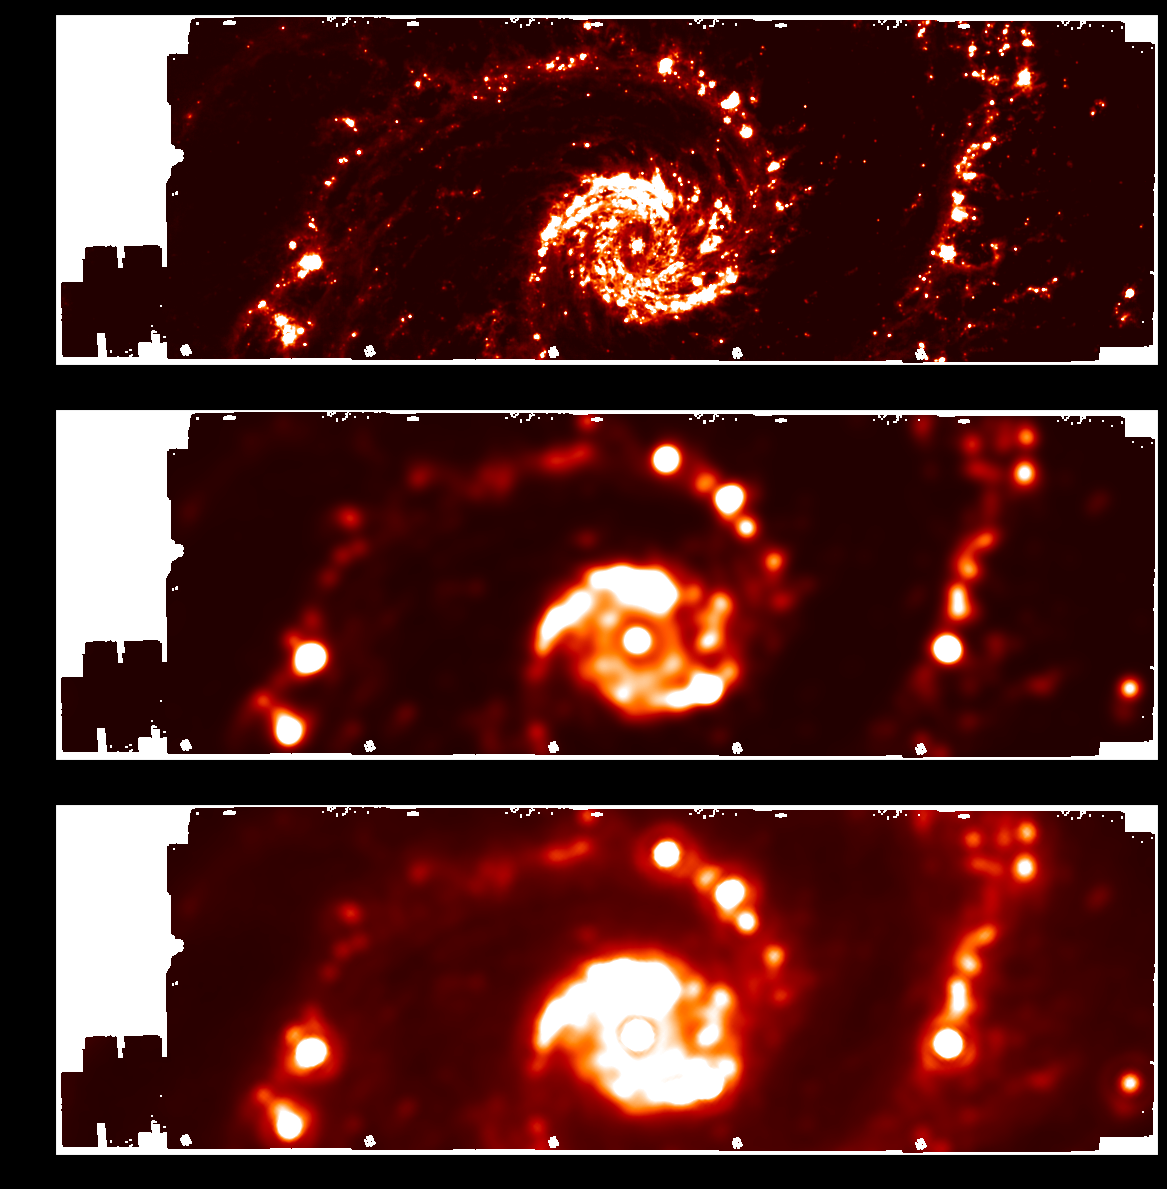

In [61]:
fig, axs = plt.subplots(3, 1, figsize=(xsize, ysize))

# Plot JWST image on top
im1 = axs[0].imshow(image_data_jwst, cmap='gist_heat', vmin=flux_min, vmax=flux_max)

# Plot convolved JWST image in the middle
im2 = axs[1].imshow(jwst_convolved, cmap='gist_heat', vmin=flux_min, vmax=flux_max)

# Plot masked reprojected MIPS image at the bottom
im3 = axs[2].imshow(reprojected_mips, cmap='gist_heat', vmin=flux_min, vmax=flux_max)

plt.tight_layout()
plt.gcf().set_facecolor("black")
plt.show()